In [ ]:
# Authors - Sahil Aneja, Rahul Ananda Bijai, Harsh Jasani
# Team - STRIVERS
# This python program is used to perform multi-class classification on medical specialty.
# The dataset(customMedicalDataset.csv) was obtained using cTAKES and Java program.


#Importing all the required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from collections import Counter


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE

import string
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer 
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# Creating a data frame for mtsamples
mtSamplesDf = pd.read_csv("/content/mtsamples.csv")
mtSamplesDf.head(n=10)

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."
5,5,Morbid obesity. Laparoscopic antecolic anteg...,Bariatrics,Laparoscopic Gastric Bypass,"PREOPERATIVE DIAGNOSIS: , Morbid obesity.,POST...","bariatrics, gastric bypass, eea anastomosis, r..."
6,6,"Liposuction of the supraumbilical abdomen, re...",Bariatrics,Liposuction,"PREOPERATIVE DIAGNOSES:,1. Deformity, right b...","bariatrics, breast reconstruction, excess, lma..."
7,7,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 3,"2-D ECHOCARDIOGRAM,Multiple views of the heart...","cardiovascular / pulmonary, 2-d echocardiogram..."
8,8,Suction-assisted lipectomy - lipodystrophy of...,Bariatrics,Lipectomy - Abdomen/Thighs,"PREOPERATIVE DIAGNOSIS: , Lipodystrophy of the...","bariatrics, lipodystrophy, abd pads, suction-a..."
9,9,Echocardiogram and Doppler,Cardiovascular / Pulmonary,2-D Echocardiogram - 4,"DESCRIPTION:,1. Normal cardiac chambers size....","cardiovascular / pulmonary, ejection fraction,..."


In [ ]:
# Creating a data frame from our generated dataset
umlsDf = pd.read_csv("/content/customMedicalDataset.csv")
umlsDf.head(n=10)

,transcription,symptoms,diseases,procedures,medications
0,"SUBJECTIVE:, This 23-year-old white female pr...","Blood Pressure, Lymphadenopathy, Pressure (fin...","Rhinitis, Infantile Neuroaxonal Dystrophy, All...","Weighing patient, Transcranial magnetic stimul...",NaN
1,"DESCRIPTION:,1. Normal cardiac chambers size....","effusion, Ejection as a Sports activity, Skin ...","Tricuspid Valve Insufficiency, Pericardial eff...",Doppler studies,NaN
2,"PREOPERATIVE DIAGNOSIS: , Right inguinal herni...","Pre-op diagnosis, Pain, Infertility, Dressing-...","Retinitis Pigmentosa, Hernia sac, Hernia, Ingu...","Spinal Anesthesia, Dressing of skin or wound, ...","Solution Dosage Form, Sponge Dosage Form"
3,"PREOPERATIVE DIAGNOSIS: , Possible inflammator...","Able (finding), Pre-op diagnosis, Post-op diag...","Disease, Inflammatory Bowel Diseases, Intestin...","Sedation procedure, Interventional procedure, ...",NaN
4,"PROCEDURE: , Colonoscopy.,PREOPERATIVE DIAGNOS...","No family history of, No abdominal pain, Movem...","Dyslipidemias, Disease, Hypertensive disease, ...","Screening colonoscopy, Screening for cancer, I...",NaN
5,"PROCEDURE: , Colonoscopy.,PREOPERATIVE DIAGNOS...","Rectal hemorrhage, Perirectal abscess, Skin ap...","Posterior pituitary disease, Perianal abscess,...","Interventional procedure, colonoscopy, Drainag...","Rectal Dosage Form, Antibiotics"
6,"PREOPERATIVE DIAGNOSIS: , Colon polyps.,POSTOP...","Rest, Pre-op diagnosis, Actual blood loss, Vis...","Colonic Polyps, Hemorrhoids, Internal hemorrhoids","Digital Rectal Examination, Interventional pro...",Rectal Dosage Form
7,"PREOPERATIVE DIAGNOSIS: , History of polyps.,P...","Blood Pressure, Morphology within normal limit...","Diverticular disease of colon, Disease, Prosta...","Electrocardiographic monitoring, Interventiona...",NaN
8,"PROCEDURE IN DETAIL: , Following instructions ...","Vision, Skin appearance normal (finding), Gait...",NaN,"Interventional procedure, colonoscopy, Total c...",Oral Dosage Form
9,"PREOPERATIVE DIAGNOSIS: , Screening. ,POSTOPER...","Pre-op diagnosis, Post-op diagnosis, Lesion, D...","bite injury, Infantile Neuroaxonal Dystrophy, ...","Digital Rectal Examination, Screening for canc...",Rectal Dosage Form


In [ ]:
# Removing Duplicate Transcriptions from mtsamples
mtSamplesDf = mtSamplesDf.drop_duplicates(subset='transcription', keep="first")
mtSamplesDf.head(n=10)

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."
5,5,Morbid obesity. Laparoscopic antecolic anteg...,Bariatrics,Laparoscopic Gastric Bypass,"PREOPERATIVE DIAGNOSIS: , Morbid obesity.,POST...","bariatrics, gastric bypass, eea anastomosis, r..."
6,6,"Liposuction of the supraumbilical abdomen, re...",Bariatrics,Liposuction,"PREOPERATIVE DIAGNOSES:,1. Deformity, right b...","bariatrics, breast reconstruction, excess, lma..."
7,7,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 3,"2-D ECHOCARDIOGRAM,Multiple views of the heart...","cardiovascular / pulmonary, 2-d echocardiogram..."
8,8,Suction-assisted lipectomy - lipodystrophy of...,Bariatrics,Lipectomy - Abdomen/Thighs,"PREOPERATIVE DIAGNOSIS: , Lipodystrophy of the...","bariatrics, lipodystrophy, abd pads, suction-a..."
9,9,Echocardiogram and Doppler,Cardiovascular / Pulmonary,2-D Echocardiogram - 4,"DESCRIPTION:,1. Normal cardiac chambers size....","cardiovascular / pulmonary, ejection fraction,..."


In [ ]:
# Removing Duplicate Transcriptions from completeDataset
umlsDf = umlsDf.drop_duplicates(subset='transcription', keep="first")
umlsDf.head(n=10)

,transcription,symptoms,diseases,procedures,medications
0,"SUBJECTIVE:, This 23-year-old white female pr...","Blood Pressure, Lymphadenopathy, Pressure (fin...","Rhinitis, Infantile Neuroaxonal Dystrophy, All...","Weighing patient, Transcranial magnetic stimul...",NaN
1,"DESCRIPTION:,1. Normal cardiac chambers size....","effusion, Ejection as a Sports activity, Skin ...","Tricuspid Valve Insufficiency, Pericardial eff...",Doppler studies,NaN
2,"PREOPERATIVE DIAGNOSIS: , Right inguinal herni...","Pre-op diagnosis, Pain, Infertility, Dressing-...","Retinitis Pigmentosa, Hernia sac, Hernia, Ingu...","Spinal Anesthesia, Dressing of skin or wound, ...","Solution Dosage Form, Sponge Dosage Form"
3,"PREOPERATIVE DIAGNOSIS: , Possible inflammator...","Able (finding), Pre-op diagnosis, Post-op diag...","Disease, Inflammatory Bowel Diseases, Intestin...","Sedation procedure, Interventional procedure, ...",NaN
4,"PROCEDURE: , Colonoscopy.,PREOPERATIVE DIAGNOS...","No family history of, No abdominal pain, Movem...","Dyslipidemias, Disease, Hypertensive disease, ...","Screening colonoscopy, Screening for cancer, I...",NaN
5,"PROCEDURE: , Colonoscopy.,PREOPERATIVE DIAGNOS...","Rectal hemorrhage, Perirectal abscess, Skin ap...","Posterior pituitary disease, Perianal abscess,...","Interventional procedure, colonoscopy, Drainag...","Rectal Dosage Form, Antibiotics"
6,"PREOPERATIVE DIAGNOSIS: , Colon polyps.,POSTOP...","Rest, Pre-op diagnosis, Actual blood loss, Vis...","Colonic Polyps, Hemorrhoids, Internal hemorrhoids","Digital Rectal Examination, Interventional pro...",Rectal Dosage Form
7,"PREOPERATIVE DIAGNOSIS: , History of polyps.,P...","Blood Pressure, Morphology within normal limit...","Diverticular disease of colon, Disease, Prosta...","Electrocardiographic monitoring, Interventiona...",NaN
8,"PROCEDURE IN DETAIL: , Following instructions ...","Vision, Skin appearance normal (finding), Gait...",NaN,"Interventional procedure, colonoscopy, Total c...",Oral Dosage Form
9,"PREOPERATIVE DIAGNOSIS: , Screening. ,POSTOPER...","Pre-op diagnosis, Post-op diagnosis, Lesion, D...","bite injury, Infantile Neuroaxonal Dystrophy, ...","Digital Rectal Examination, Screening for canc...",Rectal Dosage Form


In [ ]:
# Merging the mtsamples on our completeDataset with transcription
mergedDf = pd.merge(mtSamplesDf, umlsDf, on='transcription', how='left', indicator=True)
mergedDf.head(n=10)

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords,symptoms,diseases,procedures,medications,_merge
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller...","Blood Pressure, Lymphadenopathy, Pressure (fin...","Rhinitis, Infantile Neuroaxonal Dystrophy, All...","Weighing patient, Transcranial magnetic stimul...",NaN,both
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh...","Blood Pressure, Knee pain, Rectal hemorrhage, ...","Pseudotumor, Disease, Venous Insufficiency, Sl...","Weighing patient, Joint Examination, Knee, Rec...",Rectal Dosage Form,both
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart...","Knee pain, Does play, Rectal hemorrhage, Ankle...","Pseudotumor, Disease, Venous Insufficiency, De...","Laparoscopic bypass of stomach, Gastric Bypass...","Rectal Dosage Form, Pack",both
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple...","Pulmonary Valve Insufficiency, effusion, Press...","Tricuspid Valve Insufficiency, Pericardial eff...","Doppler studies, Enlargement procedure",NaN,both
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo...","Pulmonary Valve Insufficiency, effusion, Thick...","Michelin tire baby syndrome, Tricuspid Valve I...","Doppler studies, Obliteration procedure",NaN,both
5,5,Morbid obesity. Laparoscopic antecolic anteg...,Bariatrics,Laparoscopic Gastric Bypass,"PREOPERATIVE DIAGNOSIS: , Morbid obesity.,POST...","bariatrics, gastric bypass, eea anastomosis, r...","Pressure (finding), Pre-op diagnosis, Made red...","Adenohypophyseal Diseases, Stomach Diseases","Gastric Bypass, Roux-en-Y Anastomosis, Bypass,...","Alkalies, Sponge Dosage Form",both
6,6,"Liposuction of the supraumbilical abdomen, re...",Bariatrics,Liposuction,"PREOPERATIVE DIAGNOSES:,1. Deformity, right b...","bariatrics, breast reconstruction, excess, lma...","Projection Defense Mechanism, Wound tissue und...","Adenohypophyseal Diseases, Congenital laryngea...","Cauterization - action, Irrigation, Dressing o...","Antibiotics, Solution Dosage Form, Sponge Dosa...",both
7,7,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 3,"2-D ECHOCARDIOGRAM,Multiple views of the heart...","cardiovascular / pulmonary, 2-d echocardiogram...","effusion, Skin appearance normal (finding), Ca...",Pericardial effusion,"Echocardiography, Doppler studies, Enlargement...",NaN,both
8,8,Suction-assisted lipectomy - lipodystrophy of...,Bariatrics,Lipectomy - Abdomen/Thighs,"PREOPERATIVE DIAGNOSIS: , Lipodystrophy of the...","bariatrics, lipodystrophy, abd pads, suction-a...","Pre-op diagnosis, Infertility, Attention, Post...","Disease, Assault by stabbing, Lipodystrophy","Dressing of skin or wound, Lipectomy, Suction ...",NaN,both
9,9,Echocardiogram and Doppler,Cardiovascular / Pulmonary,2-D Echocardiogram - 4,"DESCRIPTION:,1. Normal cardiac chambers size....","cardiovascular / pulmonary, ejection fraction,...","effusion, Ejection as a Sports activity, Skin ...","Tricuspid Valve Insufficiency, Pericardial eff...",Doppler studies,NaN,both


In [ ]:
# Dropping the missing transcriptions from the merged data frame
data = mergedDf.drop(mergedDf[mergedDf['transcription'].isna()].index)

In [ ]:
# Selecting the relevant features
selectedData = data[['symptoms','diseases','procedures','medical_specialty']]
selectedData.head(n=10)

,symptoms,diseases,procedures,medical_specialty
0,"Blood Pressure, Lymphadenopathy, Pressure (fin...","Rhinitis, Infantile Neuroaxonal Dystrophy, All...","Weighing patient, Transcranial magnetic stimul...",Allergy / Immunology
1,"Blood Pressure, Knee pain, Rectal hemorrhage, ...","Pseudotumor, Disease, Venous Insufficiency, Sl...","Weighing patient, Joint Examination, Knee, Rec...",Bariatrics
2,"Knee pain, Does play, Rectal hemorrhage, Ankle...","Pseudotumor, Disease, Venous Insufficiency, De...","Laparoscopic bypass of stomach, Gastric Bypass...",Bariatrics
3,"Pulmonary Valve Insufficiency, effusion, Press...","Tricuspid Valve Insufficiency, Pericardial eff...","Doppler studies, Enlargement procedure",Cardiovascular / Pulmonary
4,"Pulmonary Valve Insufficiency, effusion, Thick...","Michelin tire baby syndrome, Tricuspid Valve I...","Doppler studies, Obliteration procedure",Cardiovascular / Pulmonary
5,"Pressure (finding), Pre-op diagnosis, Made red...","Adenohypophyseal Diseases, Stomach Diseases","Gastric Bypass, Roux-en-Y Anastomosis, Bypass,...",Bariatrics
6,"Projection Defense Mechanism, Wound tissue und...","Adenohypophyseal Diseases, Congenital laryngea...","Cauterization - action, Irrigation, Dressing o...",Bariatrics
7,"effusion, Skin appearance normal (finding), Ca...",Pericardial effusion,"Echocardiography, Doppler studies, Enlargement...",Cardiovascular / Pulmonary
8,"Pre-op diagnosis, Infertility, Attention, Post...","Disease, Assault by stabbing, Lipodystrophy","Dressing of skin or wound, Lipectomy, Suction ...",Bariatrics
9,"effusion, Ejection as a Sports activity, Skin ...","Tricuspid Valve Insufficiency, Pericardial eff...",Doppler studies,Cardiovascular / Pulmonary


In [ ]:
# Checking the missing values for the data frame
selectedData.isnull().sum()

symptoms              73
diseases             180
procedures           157
medical_specialty      0
dtype: int64

In [ ]:
# Dropping the missing values
selectedData = selectedData.dropna(how = 'any')
selectedData.shape

(2107, 4)

In [ ]:
# Checking the count of each Medical Specialty
print('Total Unique Medical Specialty in the Dataframe : ',selectedData['medical_specialty'].nunique())
print('Medcial Specialty                Count')
count = selectedData['medical_specialty'].value_counts()
count

Total Unique Medical Specialty in the Dataframe :  39
Medcial Specialty                Count


 Surgery                          927
 Radiology                        191
 Urology                          141
 General Medicine                 138
 SOAP / Chart / Progress Notes    127
 Neurology                         56
 Consult - History and Phy.        52
 Pediatrics - Neonatal             49
 Orthopedic                        45
 Psychiatry / Psychology           43
 Office Notes                      36
 Hematology - Oncology             31
 Pain Management                   30
 Gastroenterology                  30
 Obstetrics / Gynecology           24
 Nephrology                        20
 Cardiovascular / Pulmonary        19
 ENT - Otolaryngology              16
 Emergency Room Reports            15
 Discharge Summary                 15
 Ophthalmology                     13
 Physical Medicine - Rehab         10
 Bariatrics                         9
 Podiatry                           9
 Rheumatology                       8
 Sleep Medicine                     8
 Speech - La

In [ ]:
# Selecting medical specialty having count more than 40 only. Returns top 10 medical specialties
selectedData = selectedData[selectedData['medical_specialty'].isin(count[count > 40].index)]

In [ ]:
# 10 Medical Specialty is considered for the machine learning process
print('Medical Specialty having count more tha 40:')
print('Medcial Specialty                Count')
selectedData['medical_specialty'].value_counts()


Medical Specialty having count more tha 40:
Medcial Specialty                Count


 Surgery                          927
 Radiology                        191
 Urology                          141
 General Medicine                 138
 SOAP / Chart / Progress Notes    127
 Neurology                         56
 Consult - History and Phy.        52
 Pediatrics - Neonatal             49
 Orthopedic                        45
 Psychiatry / Psychology           43
Name: medical_specialty, dtype: int64

In [ ]:
# Function to Clean the Texts
def textCleaning(words): 
    words = words.translate(str.maketrans('', '', string.punctuation))
    word = ''.join([i for i in words if not i.isdigit()]) 
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
    
    lWord = word.lower()
    lWord = REPLACE_BY_SPACE_RE.sub('', lWord) 
    return lWord

# Function to Lemmatize the Texts
def textLemmatizing(words):
    wordList=[]
    lemmatization = WordNetLemmatizer() 
    sentence=sent_tokenize(words)
    
    intialSentence= sentence[0:1]
    finalSentence = sentence[len(sentence)-2: len(sentence)-1]
    
    for sentence in intialSentence:
        words=word_tokenize(sentence)
        for word in words:
            wordList.append(lemmatization.lemmatize(word))
    for sentence in finalSentence:
        words=word_tokenize(sentence)
        for word in words:
            wordList.append(lemmatization.lemmatize(word))       
    return ' '.join(wordList)

In [ ]:
# Chaning the Tpye to String for Further process
selectedData['symptoms']  = selectedData['symptoms'] .astype(str)
selectedData['diseases'] = selectedData['diseases'].astype(str)
selectedData['procedures'] = selectedData['procedures'].astype(str)

In [ ]:
# Cleaning and Lemmatizing Symptoms
selectedData['symptoms'] = selectedData['symptoms'].apply(textLemmatizing)
selectedData['symptoms'] = selectedData['symptoms'].apply(textCleaning)

# Cleaning and Lemmatizing Diseases
selectedData['diseases'] = selectedData['diseases'].apply(textLemmatizing)
selectedData['diseases'] = selectedData['diseases'].apply(textCleaning)

# Cleaning and Lemmatizing Procedures
selectedData['procedures'] = selectedData['procedures'].apply(textLemmatizing)
selectedData['procedures'] = selectedData['procedures'].apply(textCleaning)

In [ ]:
# Merging Symptoms, Diseases & Procedure  
selectedData['alldata']= selectedData['symptoms'] + selectedData['diseases'] + selectedData['procedures']
selectedData = selectedData[['alldata','medical_specialty']]
selectedData.head(n=10)

,alldata,medical_specialty
12,headache gait functional disorder medical h...,Neurology
18,sharp sensation quality dressing activity of ...,Urology
19,hypersensitivity illness finding medical h...,General Medicine
20,projection defense mechanism morphology withi...,Urology
22,infertility hemostatic functiontesticular dys...,Urology
25,infertility dressing activity of daily living...,Urology
26,hematuria blood group transfusion observation...,Urology
27,preop diagnosis actual blood loss infertilit...,Urology
28,hearing examination finding ovulation intere...,Urology
29,pain preop diagnosis infertility postop dia...,Urology


In [ ]:
# Feauture Extraction using TFIDFVectorizer to generate 2000 tf-idf features.
tfidfVectorizer = TfidfVectorizer(analyzer='word', stop_words='english',ngram_range=(1,3), max_df=0.75, use_idf=True, smooth_idf=True, max_features=2000)
tfidfMatrix = tfidfVectorizer.fit_transform(selectedData['alldata'].tolist())
featureNames = sorted(tfidfVectorizer.get_feature_names())
print(featureNames)


['abdomen', 'abdominal', 'abdominal hysterectomy', 'abdominal pain', 'abdominal pain physical', 'able', 'able finding', 'able finding pain', 'able finding preop', 'abnormal', 'abnormal degenerationposterior', 'abnormal degenerationposterior pituitary', 'abnormality', 'abortion', 'abscess', 'absence', 'absence pain', 'absent', 'abuse', 'abuse disease', 'abuse finding', 'accident', 'ache', 'action', 'action compression', 'action compression procedure', 'action gait', 'action gait normal', 'action interventional', 'action interventional procedure', 'action tissue', 'action tissue dissection', 'activated', 'activated partial', 'activated partial thromboplastin', 'activities', 'activities daily', 'activities daily living', 'activity', 'activity daily', 'activity daily living', 'activity infertility', 'activity medical', 'activity medical history', 'activity skin', 'activity skin appearance', 'actual', 'actual blood', 'actual blood loss', 'actual discomfort', 'actual discomfort pmh', 'acute'

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


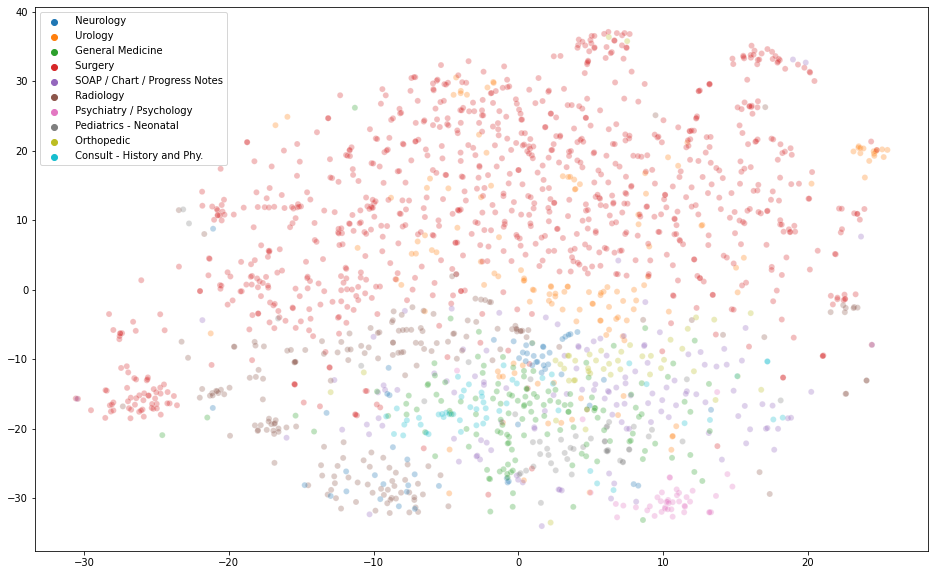

In [ ]:
# Using TSNE to visualize the tf-idf features for the medical specialty
gc.collect()
tfidfMatrixDense = tfidfMatrix.todense()
targetLabels = selectedData['medical_specialty'].tolist()
tsneValue = TSNE(n_components=2,init='random',random_state=0, perplexity=40).fit_transform(tfidfMatrixDense)
plt.figure(figsize=(16,10))
palette = sns.hls_palette(21, l=.6, s=.9)
sns.scatterplot(
    x=tsneValue[:,0], y=tsneValue[:,1],
    hue=targetLabels,
    legend="full",
    alpha=0.3
)
plt.show()

In [ ]:
# Using Principal Component Analysis to reduce the dimentionality of the features
gc.collect()
pca = PCA(n_components=0.99)
tfidfMatrixPCA = pca.fit_transform(tfidfMatrix.toarray())
targetLabels = selectedData['medical_specialty'].tolist()
categoryList = selectedData.medical_specialty.unique()
print('Shape of matrix after PCA is:'+str(tfidfMatrixPCA.shape))
X_train, X_test, y_train, y_test = train_test_split(tfidfMatrixPCA, targetLabels, stratify=targetLabels,random_state=0)  
print('X_train Size is:'+str(X_train.shape))
print('X_test Size is:'+str(X_test.shape))

Shape of matrix after PCA is:(1769, 958)
X_train Size is:(1326, 958)
X_test Size is:(443, 958)


Medical Specialty Class=  Orthopedic has Total= 34 (2.564%)
Medical Specialty Class=  General Medicine has Total= 103 (7.768%)
Medical Specialty Class=  Surgery has Total= 695 (52.413%)
Medical Specialty Class=  SOAP / Chart / Progress Notes has Total= 95 (7.164%)
Medical Specialty Class=  Radiology has Total= 143 (10.784%)
Medical Specialty Class=  Urology has Total= 106 (7.994%)
Medical Specialty Class=  Neurology has Total= 42 (3.167%)
Medical Specialty Class=  Psychiatry / Psychology has Total= 32 (2.413%)
Medical Specialty Class=  Pediatrics - Neonatal has Total= 37 (2.790%)
Medical Specialty Class=  Consult - History and Phy. has Total= 39 (2.941%)


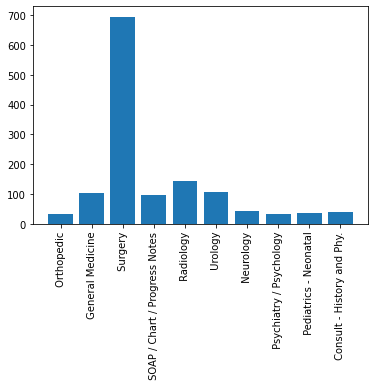

In [ ]:
# Checking the imbalance in the dataset
count = Counter(y_train)
for i,j in count.items():
	per = j / len(y_train) * 100
	print('Medical Specialty Class= %s has Total= %d (%.3f%%)' % (i, j, per))
plt.bar(count.keys(), count.values())
# added for better display
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Using Synthetic Minority Over-sampling Technique to balance the train dataset
smote = SMOTE(random_state= 0)
X_train, y_train = smote.fit_resample(X_train,y_train)
print('After SMOTE the X_train Size is:'+str(X_train.shape))
print('After SMOTE the X_test Size is:'+str(X_test.shape))

After SMOTE the X_train Size is:(6950, 958)
After SMOTE the X_test Size is:(443, 958)


Medical Specialty Class=  Orthopedic has Total= 695 (10.000%)
Medical Specialty Class=  General Medicine has Total= 695 (10.000%)
Medical Specialty Class=  Surgery has Total= 695 (10.000%)
Medical Specialty Class=  SOAP / Chart / Progress Notes has Total= 695 (10.000%)
Medical Specialty Class=  Radiology has Total= 695 (10.000%)
Medical Specialty Class=  Urology has Total= 695 (10.000%)
Medical Specialty Class=  Neurology has Total= 695 (10.000%)
Medical Specialty Class=  Psychiatry / Psychology has Total= 695 (10.000%)
Medical Specialty Class=  Pediatrics - Neonatal has Total= 695 (10.000%)
Medical Specialty Class=  Consult - History and Phy. has Total= 695 (10.000%)


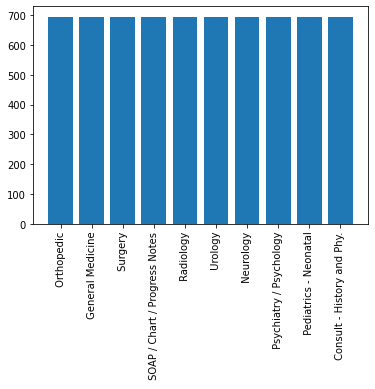

In [ ]:
# Verify the train dataset balancing after Smote
count = Counter(y_train)
for i,j in count.items():
	per = j / len(y_train) * 100
	print('Medical Specialty Class= %s has Total= %d (%.3f%%)' % (i, j, per))
plt.bar(count.keys(), count.values())
# added for better display
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Using Logistic Regression Classifier for performing the multiclass classification
lrClassifier = LogisticRegression(penalty= 'elasticnet', solver= 'saga', l1_ratio=0.5, random_state=0).fit(X_train, y_train)
lrPred= lrClassifier.predict(X_test)
targetLabels = categoryList
cmlr = confusion_matrix(y_test, lrPred)

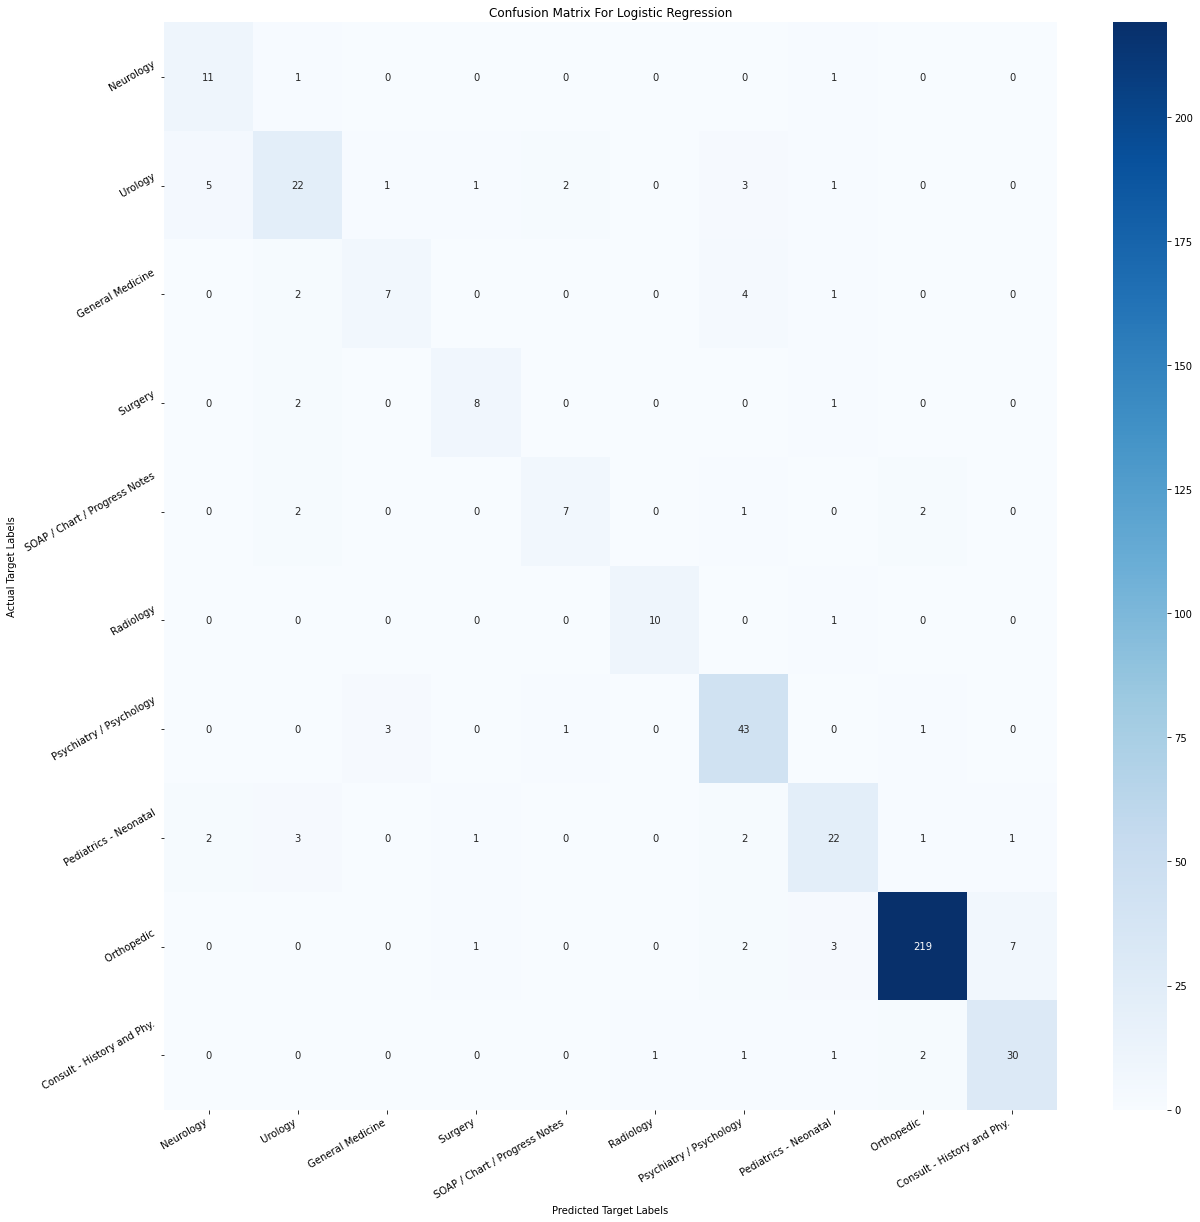

In [ ]:
# Plotting the Confusion Matrix
figureSize = plt.figure(figsize=(20,20))
pnt= figureSize.add_subplot(1,1,1)
sns.heatmap(cmlr, annot=True, cmap="Blues",ax = pnt,fmt='g');
pnt.set_xlabel('Predicted Target Labels');pnt.set_ylabel('Actual Target Labels'); 
pnt.set_title('Confusion Matrix For Logistic Regression'); 
pnt.xaxis.set_ticklabels(targetLabels); pnt.yaxis.set_ticklabels(targetLabels);
plt.setp(pnt.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(pnt.get_xticklabels(), rotation=30, horizontalalignment='right')     
plt.show()

In [ ]:
# Print the Results
print(classification_report(y_test,lrPred,labels=categoryList))

                                precision    recall  f1-score   support

                     Neurology       0.64      0.50      0.56        14
                       Urology       0.79      0.86      0.82        35
              General Medicine       0.69      0.63      0.66        35
                       Surgery       0.97      0.94      0.96       232
 SOAP / Chart / Progress Notes       0.71      0.69      0.70        32
                     Radiology       0.77      0.90      0.83        48
       Psychiatry / Psychology       0.91      0.91      0.91        11
         Pediatrics - Neonatal       0.70      0.58      0.64        12
                    Orthopedic       0.73      0.73      0.73        11
    Consult - History and Phy.       0.61      0.85      0.71        13

                      accuracy                           0.86       443
                     macro avg       0.75      0.76      0.75       443
                  weighted avg       0.86      0.86      0.86 